# Desafio Técnico PDI 

📌 **OBJETIVO** - Considerando que a imagem em questão (encarte de supermercado) será processada por algoritmos de PDI e NLP, você como desenvolverdor do time de processamento de imagens tem a missão de aplicar à imagem algoritmos de pré-processamentos com o objetivo de destacar as regiões de interesse sabendo que cada oferta (nome e preço do produto) serão extraídos pelo time de NLP. Agora é com você, dev PDI ! Dado a imagem em anexo, escreva um código para aplicar os melhores pré-processamentos possíveis, preparando a imagem para o time de NLP.

> NUVEN - Núcleo de Visão Computacional e Engenharia

> Processo seletivo para a vaga **Desenvolvedor(a) em Processamento de Imagens**

> Andressa Gomes Moreira

## Teste Reconhecimento de Dígitos

> Teste utilizando o modelo de rede neural convolucional para reconhecimento dos dígitos referente ao preço dos produtos.

**Importações**

In [1]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import imutils
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

**Carregando o modelo CNN**

In [2]:
model = load_model('./modelo/CNN_digitos_OCR.h5')

**Carregando a imagem para o teste**

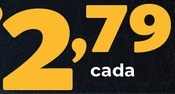

In [3]:
img = cv2.imread('./imagens/img_seg_cnn_original.jpg')
cv2_imshow(img)

**Fazendo as transformações nas imagens**

* As transformações serão iguais as apresentadas no arquivo pre_processamento_imagens.py:

    1) Escala de Cinza

    2) Suavização da imagem com Filtro Bilateral

    3) Detecção das bordas com Filtro de Canny

    4) Morfologia Matemática = Dilatação
    
    5) Morfologia Matemática = Erosão

In [4]:
# Transforma a imagem para escala de cinza
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Suavização da imagem
img_suavizada_seg_cnn = cv2.bilateralFilter(gray, 3, 75, 75)

# Detector de bordas de Canny 
bordas = cv2.Canny(img_suavizada_seg_cnn, 40, 150)

# Dilatar a imagem
img_dilatacao = cv2.dilate(bordas, np.ones((3,3)))

# Erosão da imagem
img_erosao = cv2.erode(img_dilatacao, np.ones((3,3)))

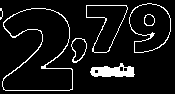

In [5]:
cv2_imshow(img_erosao)

**Encontrar contornos da imagem**

In [6]:
def define_contornos(img):
    """
    Função para encontrar os contornos presentes na imagem.

    Args:
        img: Imagem analisada
        
    Returns:
        contornos: Retorna os contornos
    """
    contornos = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contornos = imutils.grab_contours(contornos)
    contornos = sort_contours(contornos, method='left-to-right')[0]
    return contornos

contornos = define_contornos(img_erosao.copy())

**Redimensionar a imagem**

In [7]:
caracteres = []

def redimensiona_img(img, l, a):
    """
    Função para regimensionar a imagem.

    Args:
        img: Imagem analisada
        l: largura da imagem
        a: altura da imagem
        
    Returns:
        contornos: Retorna imagem redimensionada 28x28
    """
    
    red_img = imutils.resize(img, width=28) if  l > a else imutils.resize(img, height=28)

    (a, l) = red_img.shape
    dX = int(max(0, 28 - l) / 2.0)
    dY = int(max(0, 28 - a) / 2.0)

    img_preenchida = cv2.copyMakeBorder(red_img, top=dY, bottom=dY, right=dX, left=dX, 
                                        borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    img_preenchida = cv2.resize(img_preenchida, (28, 28))
    return img_preenchida

**Definir as caixas delimitadoras de cada dígito**

In [8]:
def define_caixa_delimitadora(gray, x, y, w, h):
    """
    Função para definir o tamanho das caixas delimitadoras para cada dígito na imagem

    Args:
        gray: Imagem em tons de cinza
        x: coordenada x coordinate
        y: coordenada y
        w: largura
        h: altura
        
    Returns:
        None
    """
    roi = gray[y:y + h, x:x + w]
    thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    (a, l) = thresh.shape
    img_red = redimensiona_img(thresh, l, a)
    
    cv2_imshow(img_red)
    
    normalizada = img_red.astype('float32') / 255.0
    normalizada = np.expand_dims(normalizada, axis=-1)
    
    caracteres.append((normalizada, (x, y, w, h)))

In [9]:
l_min, l_max = 4, 80
a_min, a_max = 45, 500

for contorno in contornos:
    (x, y, w, h) = cv2.boundingRect(contorno)
    if (h >= a_min and h <= a_max):
        define_caixa_delimitadora(gray, x, y, w, h)

In [10]:
caixas = [caixa[1] for caixa in caracteres]
caracteres = np.array([c[0] for c in caracteres], dtype='float32')

**Fazendo a previsão dos resultados**

In [11]:
lista_caracteres = [l for l in "0123456789"]
previsoes = model.predict(caracteres)

1/1 [==============================] - 0s 285ms/step


Caractere Extraído: 2
Probabilidade = 99.96829032897949


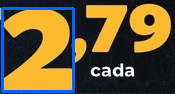

Caractere Extraído: 7
Probabilidade = 92.56790280342102


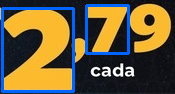

Caractere Extraído: 9
Probabilidade = 94.8762059211731


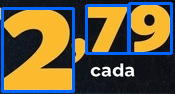

In [12]:
img_cp = img.copy()

for (previsoes, (x, y, w, h)) in zip(previsoes, caixas):
    i = np.argmax(previsoes)
    cv2.rectangle(img_cp, (x, y), (x + w, y + h), (255,100,0), 2)
    print(f'Caractere Extraído: {lista_caracteres[i]}\nProbabilidade = {previsoes[i] * 100}')
    
    cv2_imshow(img_cp)